# Capstone: Sentiment Analysis for CMON
## Data Cleaning, Pre-processing and EDA

## Problem Statement

CMON is a listed company on the HK stock Exchange that sells it's boardgames through a suite of online platforms. It brings boardgames to live by Kickstarter funding and boardgames would go into production once the funding quota is met.

In order to come up with games that are appealing to consumers, it is imperative for CMON to identify customer sentiments, their likes and dislikes and painpoints.

For phase 1 of this project, the data science team has been tasked to classify positive and negative reviews on Boardgamegeeks.com for all of CMON's games using Natural Language Procesisng (NLP).

The model that achieves the highest accuracy and recall on the validation set would be selected for production. The team would also be identifying the key contributors for the classifications.

For phase 2 of the project, the team would be looking at building a recommeder system for CMON based on ratings of the board games.

Phase 1 is crucial for the chief creative director so that CMON is able to understand what consumers like or dislike in their board games so that resources can be channeled to ensuring that the games they launch on kickstarter can be fully and hopefully over subscribed.

Phase 2 would enhance their company's sales by recommending games that players enjoy to encourage purchase.

Deadline for phase 1 would be by the beginning of August 2020 and phase 2 rollout would be dependent on the successful completion of phase 1.


## Data Guidelines

Data has been scapped from https://boardgamegeek.com/ for all CMON games. Script is used to scrape all the ratings and comments for all CMON boardgames and saved into CSV format. There are 4 columns including the index.
Other columns include the username ( registered user name for the forum), ratings given by user for the boardgame (from 1 to 10) and comments from the user.

Ratings from 5 and below would be deemed to be negative, ratings from 6 to 10 would be deemed to be positive.

There is one csv for each board games and the data would be compiled for review. Preliminary assessment indicates that there would be approximately 16K rows.

They would be split into 50% (train-test) set and 50% holdout set.

The comments column would be lemmatize/ tokenised into useful words.

Data cleaning:

Remove duplicated reviews
Remove reviews that do not have any meaningful words
Remove reviews that are non-English or gibberish
Pre-processing:

Remove HTML tags
Use regular expression to remove special characters and numbers
Lowercase words
Use NLTK to remove stopwords
Remove common occurring words that appear in both positive and negative sentiments
Use NLTK to stem words to their root form

# Importing Libraries

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import regex as re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from os import path
from PIL import Image
import requests

# Libraries for topic modeling
from pprint import pprint
import gensim
import spacy
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import pyLDAvis.gensim

%matplotlib inline

## EDA Guidelines

EDA would be performed on the the comments.

1. Wordcloud to visualise keywords
2. Count to visualise keywords
3. Plot to identify distribution of valuable words

etc

## Importing CSV

In [37]:
# Import all .csv files under datasets folder
path = r'../GA Capstone CMON/datasets'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
df = pd.concat(df_from_each_file, ignore_index=True)

In [38]:
df.shape

(23846, 4)

In [39]:
# Check that the data has been re-indexed
df.tail()

,Unnamed: 0,username,rating,comment
23841,2528,Zyrallus,3.8,"So much potential here. Seriously, with a less..."
23842,2529,zyx0xyz,7.6,唯一的亮点就是模型和版图美工了，但本人作为一个十多年的生化危机fans，体验zombicid...
23843,2530,zzool73,8.0,If you are creative there are a lot of house r...
23844,2531,_ph_,9.0,"Still playing a lot of the game with friends, ..."
23845,2532,_The_Inquiry_,4.0,Prior to 2020: 1 play\n\nIf there's a single g...


In [40]:
# Drop selftext duplicates as we only want unique posts
df.drop_duplicates('comment', inplace=True)

In [41]:
df.shape

(21872, 4)

In [42]:
# drop comments with no ratings
df = df.dropna(subset=['rating'])

In [43]:
df.shape

(16859, 4)

## Fill NA

In [44]:
# Check for null values
df.isnull().sum()

Unnamed: 0    0
username      0
rating        0
comment       1
dtype: int64

In [45]:
df['comment'].fillna('', inplace=True)

In [46]:
# Double check if there is anymore NA in comment
df.isnull().sum()

Unnamed: 0    0
username      0
rating        0
comment       0
dtype: int64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16859 entries, 1 to 23845
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  16859 non-null  int64  
 1   username    16859 non-null  object 
 2   rating      16859 non-null  float64
 3   comment     16859 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 658.6+ KB


In [48]:
# Check how many comments were retrieved from each rating
df['rating'].value_counts().sort_index()

1.00000      183
1.10000        1
1.30000        1
1.50000        2
1.60000        1
2.00000      138
2.40000        2
2.43300        1
2.50000        6
2.87000        1
3.00000      286
3.20000        1
3.30000        1
3.33000        3
3.40000        1
3.50000       12
3.75000        1
3.80000        3
3.90000        2
4.00000      419
4.10000        2
4.13000        1
4.28000        1
4.29238        1
4.30000        1
4.40000        1
4.44000        1
4.50000       16
4.60000        1
4.65500        1
4.70000        2
4.75000        1
4.80000        1
4.85000        1
4.90000        4
4.98500        1
4.99000        1
5.00000      767
5.10000        2
5.20000        4
5.30000        1
5.40000        3
5.41917        1
5.45000        1
5.50000       89
5.60000        3
5.67000        1
5.70000        4
5.75000        6
5.80000        7
5.84000        1
5.90000        8
5.93000        1
5.95000        1
6.00000     1582
6.00100        1
6.02000        1
6.10000        7
6.16000       

## Data Preprocessing

Pre-processing would enable transformation of our text into a more digestible form so that our classifier can perform better. The steps taken is as follows:

- 1. Remove html tags using beautifulsoup
- 2. Lowercase all words and split word up
- 3. Remove non-letters: Remove special characters and numbers
- 4. Remove keywords that points to a speciic subreddit
- 5. Remove stopwords: These are common words that are not useful for text classification
- 6. Lemmatize words: This will convert each word to its base form
- 7. Finally, rejoin words back into a string

In [49]:
# remove bs4 warnings as scrapping includes pinned moderator posts with many url links and pictures
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [50]:
# Initialise Lemmatizer
lemmatizer = WordNetLemmatizer()

In [51]:
# Write a function to convert text to a string of meaningful words
def meaningful_text(self_text):
    
    # 1. Remove html tags
    words = BeautifulSoup(self_text).get_text()
    
    # 2. Convert words to lower case and split each word up
    words = self_text.lower()
    
    # iphon likely to be spelling error for iphone, removing it as we do not want iphone inside too
    #words = words.replace('iphon', '') 
    
    # 3. Remove non-letters
    words = re.sub("[^a-zA-Z]", " ", words).split()    
    
    #Searching through a set is faster than searching through a list,so we will convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # 4. Add certain keywords to stopwords as its too obvious for which reddit
    #stops.update(['Android','Iphone','android','iphon','phone','http','www','com', 'Iphon','IPHON'])
    
    # 5. Remove stopwords
    meaningful_words = [w for w in words if w not in stops]
    
    # 6. Lemmatize words
    meaningful_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
   
    # 7. Join words back into one string, with a space in between each word
    return(" ".join(meaningful_words))

In [52]:
# Creating clean selftext and clean title, and store them in new columns
df['comment_clean'] = df['comment'].map(meaningful_text)

In [53]:
df.head()

,Unnamed: 0,username,rating,comment,comment_clean
1,1,abraxasdf,10.0,Should not let you rate a game before it even ...,let rate game even release
8,8,AlphaLoR,8.0,Cant wait! :),cant wait
9,9,andreasrem1980,10.0,Will put normal rate after preorder arrives. T...,put normal rate preorder arrives adjust point ...
10,10,annie90,4.0,cool,cool
11,11,Arah,9.8,[b]Ankh Micro Review:[/b]\nI have always had a...,b ankh micro review b always admiration abstra...


### Comparison between original comment and lemmatized comment

In [54]:
# original comment
df.loc[1]['comment']

'Should not let you rate a game before it even releases'

In [55]:
# lemmatized comment
df.loc[1]['comment_clean']

'let rate game even release'

### Remove comments that do not have any meaningful words

In [56]:
# Find the number of comments with no meaningful words
df['number_of_words'] = df['comment_clean'].str.split().map(len)
df[df['number_of_words']==0].shape

(274, 6)

In [57]:
df[df['number_of_words']==0]['comment']

290                                                 [4]2-4
324                                               豪华美式入门礼包
353                                                     1 
389                                                   * 10
439                                                      S
479                                                  2 3 4
546                                                     \n
584                                                    8.5
606                                                   2.51
630                                                      M
674      机制比较完整的美式。\n玩家互动、重开性都较强。\n缺点也比较明显，游戏时长太长，玩家需要操...
723      재밌어서 도색까지 하게 된 미니어쳐 게임. 주사위가 터질때의 손맛이 짜릿짜릿하다. ...
789                                                     4º
810      這是個打怪遊戲還是打死其他英雄的遊戲！？三個角色讓你分配裝備，全數把最強的給一個感覺太冒險，...
901                                                      .
992                                                    1-1
1033                                               4 (2-

In [58]:
# drop no meaningful word comments
for i in df[df['number_of_words']==0].index:
    no_meaningful_word = df.loc[i]['comment']
    df.drop(i, inplace=True)

In [59]:
# reset index
df.reset_index(drop=True, inplace=True)

## Set a target variable

Set a target variable base on ratings.<br>
Negative comment (with rating 1-7): 0<br>
Positive comment (with rating 8-10): 1

In [60]:
df['target'] = df['rating'].map(lambda x: 1 if x >= 8 else 0)

In [61]:
df['target'].value_counts()

1    8519
0    8066
Name: target, dtype: int64

In [62]:
df.head()

,Unnamed: 0,username,rating,comment,comment_clean,number_of_words,target
0,1,abraxasdf,10.0,Should not let you rate a game before it even ...,let rate game even release,5,1
1,8,AlphaLoR,8.0,Cant wait! :),cant wait,2,1
2,9,andreasrem1980,10.0,Will put normal rate after preorder arrives. T...,put normal rate preorder arrives adjust point ...,8,1
3,10,annie90,4.0,cool,cool,1,0
4,11,Arah,9.8,[b]Ankh Micro Review:[/b]\nI have always had a...,b ankh micro review b always admiration abstra...,707,1


## Create train test set

In [63]:
X = df[[cols for cols in df.columns if cols != 'target']]
y = df['target']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Rejoin training and testing dataset, and reindex

In [65]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Training set has 13268 documents

In [66]:
train.shape

(13268, 7)

Testing set has 3315 documents

In [67]:
test.shape

(3317, 7)

Baseline model for training and testing set

In [68]:
train['target'].value_counts(normalize=True)

1    0.513642
0    0.486358
Name: target, dtype: float64

In [69]:
test['target'].value_counts(normalize=True)

1    0.513717
0    0.486283
Name: target, dtype: float64

## WordCloud to visualize keywords

In [70]:
stops = set(stopwords.words('english'))
stops.update(['game','play','player','really','one','card'])

In [71]:
def plot_wordcloud(target, title):
    text = df[df['target']==target]['comment_clean'].values # Clean text that we want to wordcloud
    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=200,
                         stopwords=stops).generate(str(text))
    plt.figure(figsize=(12,10))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Removes the axis

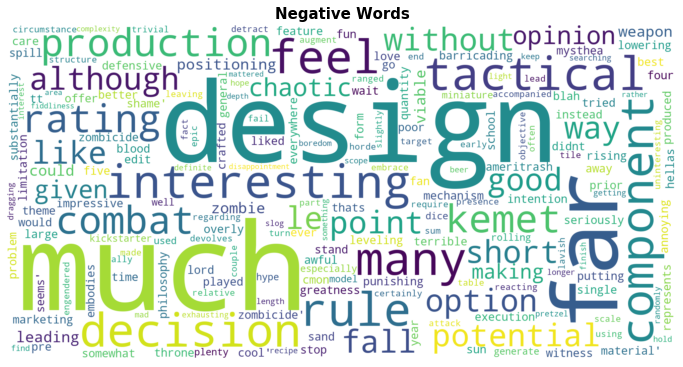

In [72]:
plot_wordcloud(0, 'Negative Words')

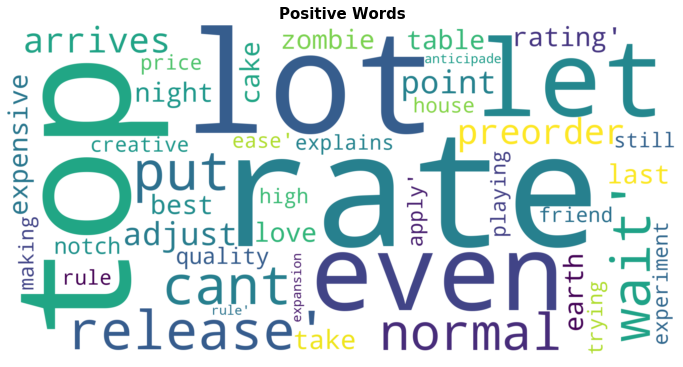

In [73]:
plot_wordcloud(1, 'Positive Words')

## Count to visualise keywords

In [74]:
stops.update(['game','play','player','really','one',
              'card','like', 'fun','good','get'])

In [75]:
def barplot_cvec(target, title, color):
    
    words_series = df[df['target']==target]['comment_clean']
    
    # Instantiate CountVectorizer 
  
    cvec = CountVectorizer(stop_words=stops)
    
    # Save the tokens in a dataframe
    cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names())
    sum_words = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    top_words = sum_words.sort_values(ascending=False).head(20)
    top_words.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Count', fontsize=12)
    plt.xlim(0,1500) # Setting a limit for barplot

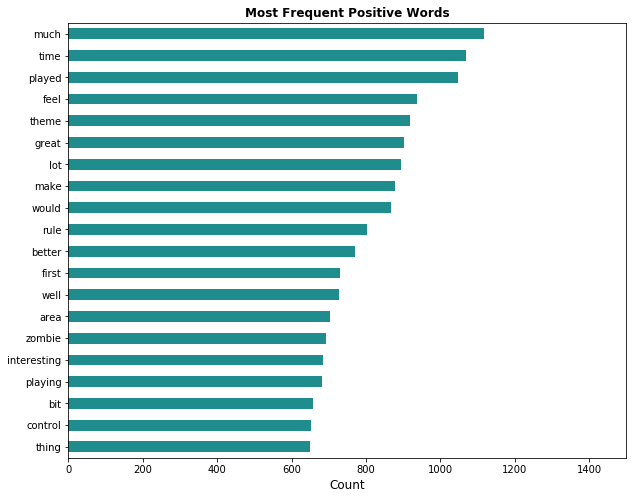

In [76]:
barplot_cvec(0,'Most Frequent Positive Words','#1f8d8d')

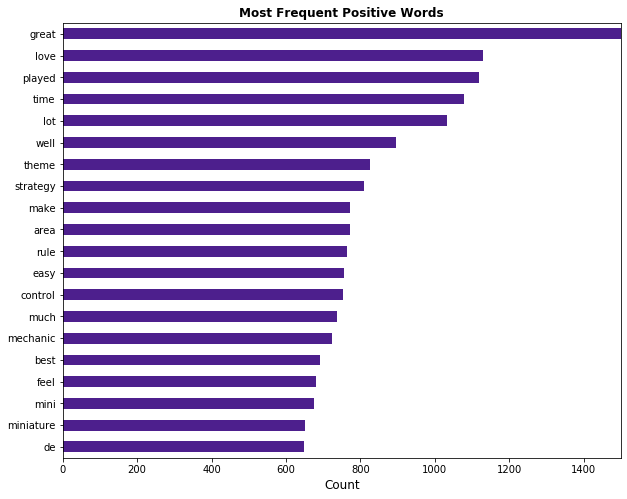

In [77]:
barplot_cvec(1,'Most Frequent Positive Words','#4d1f8d')

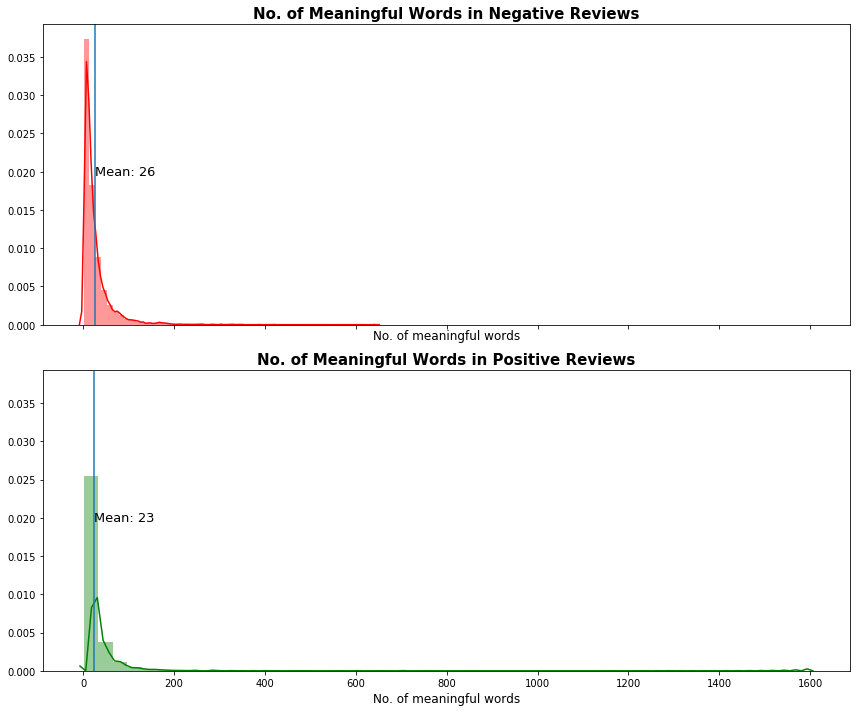

In [94]:
fig, ax = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=True)

# Plots the distribution of the length of negative reviews
neg_len = train[train['target']==0]['number_of_words']
sns.distplot(neg_len, color='red', ax=ax[0])
ax[0].axvline(neg_len.mean()) # Plot the mean line
ax[0].text(x=neg_len.mean(),
           y=0.02,
           s=f'Mean: {round(neg_len.mean())}', 
           horizontalalignment='left', 
           verticalalignment='center',
           fontsize=13)
ax[0].set_title('No. of Meaningful Words in Negative Reviews', fontsize=15, fontweight='bold')
ax[0].set_xlabel('No. of meaningful words', size=12)

# Plots the distribution of the length of positive reviews
pos_len = train[train['target']==1]['number_of_words']
sns.distplot(pos_len, color='green', ax=ax[1])
ax[1].axvline(pos_len.mean()) # Plot the mean line
ax[1].text(x=pos_len.mean(),
           y=0.02,
           s=f'Mean: {round(pos_len.mean())}', 
           horizontalalignment='left', 
           verticalalignment='center',
           fontsize=13)
ax[1].set_title('No. of Meaningful Words in Positive Reviews', fontsize=15, fontweight='bold')
ax[1].set_xlabel('No. of meaningful words', size=12)
plt.tight_layout();

In [82]:
# Create a list of all the textual data from negative reviews
data = train[train['target']==0]['comment'].values.tolist()

In [83]:
# Assign NLTK's stopwords to stop_words
stop_words = stopwords.words('english')

# Include frequently occuring words
stop_words.extend(['game','play','player','really','one','card'])

In [95]:
# Remove stopwords, lemmatize and only keep tokens that fall into these part of speech tags
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        # Lemmatize and only keep tokens that have certain part of speech tags
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) 
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# Pre-processing text
data_ready = process_words(data)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [89]:
pip install -U spacy

Requirement already up-to-date: spacy in c:\users\kkc3\anaconda3\lib\site-packages (2.3.2)
Note: you may need to restart the kernel to use updated packages.
